In [1]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap/python')
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asap')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
import asapc 
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet(data_mode='mtx',data_ondisk=False)
dl.config = args
dl.initialize_path()
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/temp/temp
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/temp/temp


In [2]:
dl.load_data()
asap = ASAPP(adata=dl,factorization='VB', max_iter=100)
asap.get_pbulk()

In [3]:
asap.pbulk_mat.shape

(656, 10000)

In [4]:

K = 5
nmfm = asapc.ASAPNMFAlt(asap.pbulk_mat.T,K)
nmf = nmfm.run()

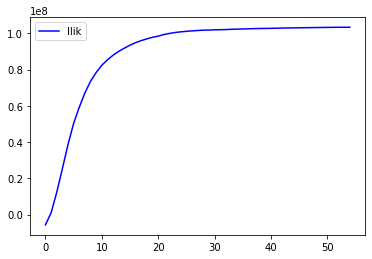

In [5]:
plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

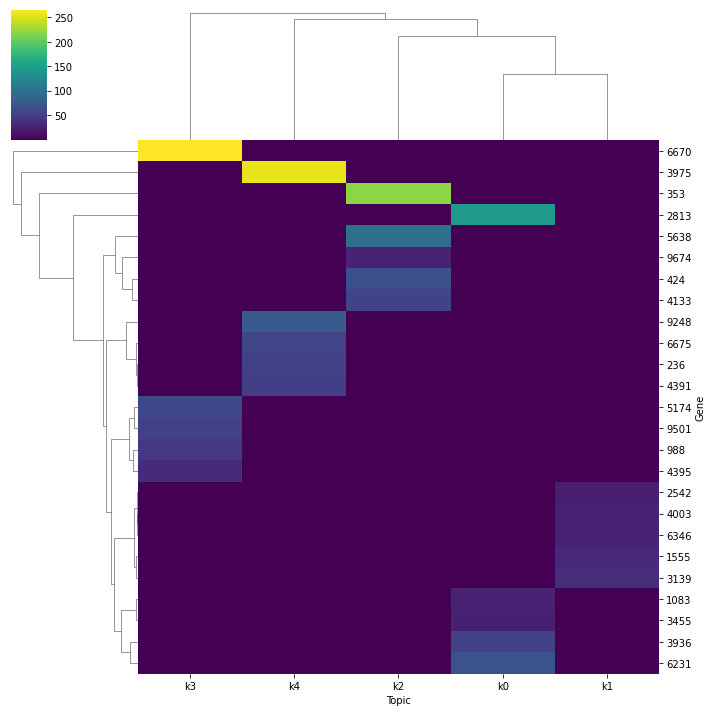

In [6]:
df_beta = pd.DataFrame(nmf.beta.T)
df_beta.columns = dl.cols
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
regm = asapc.ASAPREG(dl.mtx.T,nmf.beta)
reg = regm.regress()

In [ ]:
beta = nmf.beta
theta = reg.A
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz


In [8]:
df_pl = pd.DataFrame(dl.rows)
df_pl.columns = ['cell']

In [9]:
import umap


df_theta = pd.DataFrame(reg.corr)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

df_pl['cell_type'] = df_umap['topic']

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap



,cell,topic,umap1,umap2,cell_type
0,1,3,16.884869,13.998050,3
1,2,2,10.744124,0.962201,2
2,3,0,0.075204,9.560328,0
3,4,1,0.693793,-1.576326,1
4,5,1,1.810146,-1.879903,1
...,...,...,...,...,...
2995,2996,1,-0.217812,0.068384,1
2996,2997,3,16.858601,13.890006,3
2997,2998,3,17.852612,9.251701,3
2998,2999,4,-8.386568,12.486297,4


Text(0.5, 1.0, 'ASAP')

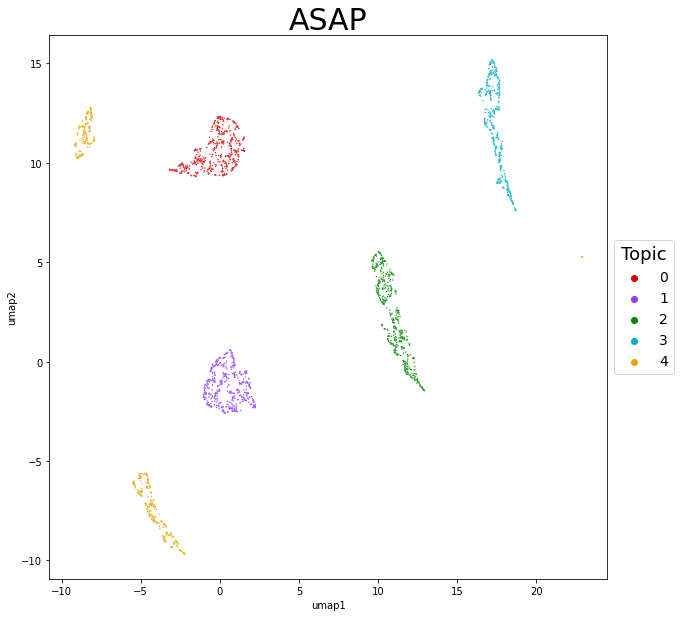

In [10]:
plt.rcParams["figure.figsize"] = (10,10)

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("ASAP",fontsize=30)